The below cell imports all the necessary classes required in building the model and analysis

In [1]:
# Keras Imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import binary_crossentropy


# Sci-kit learn imports
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

Using TensorFlow backend.


First, let us visualize the images of infected and uninfected cells.

In [2]:
# Path array of infected cell images
infected_cells=glob.glob("../input/cell_images/cell_images/Parasitized/*.png")
uninfected_cells=glob.glob("../input/cell_images/cell_images/Uninfected/*.png")

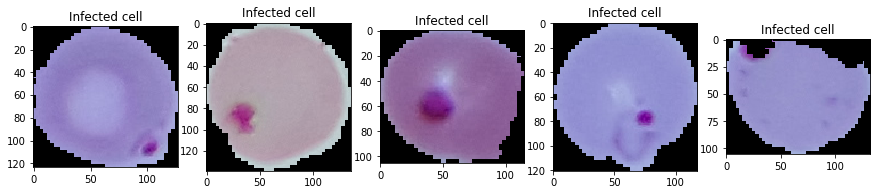

In [3]:
plt.figure(figsize=(15,15))
for i in range(1,6):
    plt.subplot(1,5,i)
    ran=np.random.randint(100)
    plt.imshow(cv2.imread(infected_cells[ran]))
    plt.title('Infected cell')

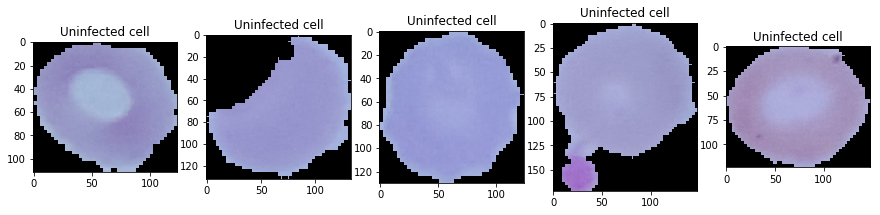

In [4]:
plt.figure(figsize=(15,15))
for i in range(1,6):
    plt.subplot(1,5,i)
    ran=np.random.randint(100)
    plt.imshow(cv2.imread(uninfected_cells[ran]))
    plt.title('Uninfected cell')

Since the data is in raw format, we convert it into rgb array and reshape it in the form of feature vector. Then depending on the image, we add an appropriate label to its correspnding index.

In [5]:
# Create feature and response matrix for the image data
image_arr=list()
label=list()

for i in infected_cells:
    img=cv2.imread(i)
    img_res=cv2.resize(img,(64,64))
    image_arr.append(img_res)
    label.append(1)

for j in uninfected_cells:
    img=cv2.imread(j)
    img_res=cv2.resize(img,(64,64))
    image_arr.append(img_res)
    label.append(0)

In [6]:
del img,infected_cells,uninfected_cells

In [7]:
# List to Array Conversion and lengths
image_arr=np.array(image_arr)
label=np.array(label)
image_arr.shape, label.shape

((27558, 64, 64, 3), (27558,))

From the above images, we can clearly distinguish that the cells with red(or pink) color blobs are being categorized as infected cells. Let us divide the data into training and testing data


In [8]:
# Shuffling of data since all 1s' and 0s' have been appended together

image_arr, label = shuffle(image_arr, label, random_state=0)

# Train-Test split

X_train, X_test, y_train, y_test=train_test_split(image_arr,label,test_size=0.2, random_state=0)

In [9]:
type(X_train)
type(y_train)

numpy.ndarray


We must perform image augmentation on the existing images to make the neural network more versatile. In common words, we apply several transformation techniques like scaling, shearing, rotation etc. to the existing images. This causes the model to be trained in such a way that it can detect even the most uncommon of occurences.

In [10]:
# Image Augementation

## Generic Image Data Generator 
train_generator=ImageDataGenerator(rotation_range=20,width_shift_range=0.25,height_shift_range=0.25,shear_range=0.2,zoom_range=0.3,horizontal_flip=True,vertical_flip=True,rescale=1/255.)
test_generator=ImageDataGenerator(rescale=1/255.)

# Applying generators to training and testing images with additional parameters
train_gen=train_generator.flow(X_train,y_train,batch_size=128,shuffle=False)
test_gen=test_generator.flow(X_test,y_test,batch_size=1,shuffle=False)

In [11]:
type(X_train)
type(y_train)

numpy.ndarray


Let us create our neural network. A neural network in general consists of Convolution, Pooling, Flatten and Dense layers. The function of each of the mentioned layers can be understood by going through the theory involved in building a CNN.

In [12]:
# Function to build a neural network

def CNN_neural():
    # Indicates that our model is built using Sequential layers
    model=Sequential()
    
    # First, we add multiples convolution layers to find patterns
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu',input_shape=(64,64,3)))
    # Next, we add Pooling layer to reduce the size and find the occurence of feature in the convolution set
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Scales the outputs of previous layers
    model.add(BatchNormalization(axis=-1))
    
    # We repeat the same to create a slightly complex model
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu',name = 'f1'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization(axis=-1))
    
    # To prevent overfitting
    model.add(Dropout(0.25))
    
    # Now we begin the construction of ANN with the above network output as input
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.25))
    model.add(Dense(1,activation='sigmoid'))
    
    return model
    

Now, we compile the above model with appropriate optimizers and metrics to build a final model

In [13]:
model=CNN_neural()
model.compile(loss=binary_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
f1 (Conv2D)                  (None, 12, 12, 32)        9248      
__________

We are done with preliminary steps and are now ready to fit the model to the augmented data.

In [14]:
# Fitting a model to the data

hist=model.fit_generator(train_gen,steps_per_epoch=len(X_train)/32,epochs=25)

Epoch 1/25
689/688 [==============================] - 104s 152ms/step - loss: 0.3561 - acc: 0.8503
Epoch 2/25
689/688 [==============================] - 100s 145ms/step - loss: 0.2493 - acc: 0.9076
Epoch 3/25
689/688 [==============================] - 100s 146ms/step - loss: 0.2302 - acc: 0.9143
Epoch 4/25
689/688 [==============================] - 99s 144ms/step - loss: 0.2221 - acc: 0.9182
Epoch 5/25
689/688 [==============================] - 101s 146ms/step - loss: 0.2154 - acc: 0.9202
Epoch 6/25
689/688 [==============================] - 100s 145ms/step - loss: 0.2114 - acc: 0.9220
Epoch 7/25
689/688 [==============================] - 100s 145ms/step - loss: 0.2089 - acc: 0.9225
Epoch 8/25
689/688 [==============================] - 101s 146ms/step - loss: 0.2064 - acc: 0.9241
Epoch 9/25
689/688 [==============================] - 100s 146ms/step - loss: 0.2035 - acc: 0.9246
Epoch 10/25
689/688 [==============================] - 99s 144ms/step - loss: 0.2018 - acc: 0.9250
Epoch 11/25

Since we have developed the model, let us have a look at how it performed over the epochs timeline.

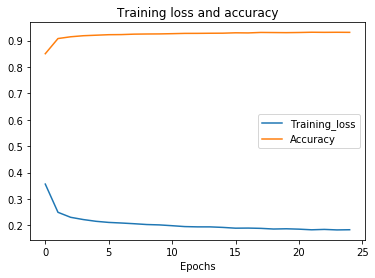

In [15]:
# Diagnostics

N=25
plt.plot(np.arange(0,N),hist.history['loss'],label='Training_loss')
plt.plot(np.arange(0,N),hist.history['acc'],label='Accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.legend(loc='right')

Next, we evaluate the test error associated with this model.

In [16]:
test_err=model.evaluate_generator(test_gen,steps=len(y_test))

In [17]:
# Test Accuracy

print('Loss: ',test_err[0])
print('Accuracy: ',test_err[1])


Loss:  0.11524341891440791
Accuracy:  0.9615384615384616


In [18]:
#save model
model.save(r"model_64*64*3.h5")